In [43]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import sys


from helpers.physics_functions import get_bins
from helpers.stats_functions import parametric_fit, curve_fit_m_inv, calculate_test_statistic, integral
from helpers.evaluation import get_median_percentiles

from helpers.stats_functions import calculate_test_statistic
from helpers.plotting import newplot, hist_with_outline, hist_with_errors, function_with_band, stamp
# warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib.font_manager")

# Try to load LaTeX
latex_flag = False
np.seterr(divide='ignore')



{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

This notebook should be run twice:

1. `train_samesign = False` gives the "standard" results. i.e. we run the studies on the OS samples
2. `train_samesign = True` comes from running the Ml study on the SS samples.

**CAUTION**: for the histograms, we are truly showing the significance as $\frac{S}{\sqrt{B+{\sigma_B}^2}}$, i.e. we are accounting for the background error. For the ROC curves, this error is *NOT* being taken into account (it's not clear to me that we want this background error when we are just citing the background yield for the FPR)

In [44]:
import yaml
with open("workflow.yaml", "r") as file:
    workflow = yaml.safe_load(file) 
    
feature_id = "mix_2"
bootstrap_flow = 0 # don't change this from 0

train_samesign = False
# somewhat complicated code to set naming conventions
if train_samesign:
    train_data_id = "SS"
else:
    train_data_id = "OS"

# train on opp sign means alt test set is samesign
if train_data_id == "OS": 
    alt_test_data_id = "SS"
elif train_data_id == "SS": 
    alt_test_data_id = "OS"

configs = "CATHODE_8"


# pickles contain all the results from the BDT training
working_dir = workflow["file_paths"]["working_dir"]
processed_data_dir = workflow["file_paths"]["data_storage_dir"] +"/projects/"+workflow["analysis_keywords"]["name"]+"/processed_data"
flow_training_dir = workflow["file_paths"]["data_storage_dir"] +"/projects/" + workflow["analysis_keywords"]["name"]+f"/models/bootstrap{bootstrap_flow}_{train_data_id}/{feature_id}/{configs}/"
pickle_save_dir = workflow["file_paths"]["data_storage_dir"] +"/projects/" + workflow["analysis_keywords"]["name"]+f"/pickles/bootstrap{bootstrap_flow}_{train_data_id}/{feature_id}/"
plot_data_dir = "plot_data/"

# basically hard-coded for the PRL 
num_pseudoexperiments = 1
n_folds = 5

In [45]:
num_bins_SR = 12 # 16, 12, 8

pseudo_e_to_plot = 0 # this plots the actual data (not a boostrapped version)
bkg_fit_degree = 5

In [46]:
SB_left = float(workflow["window_definitions"][workflow["analysis_keywords"]["particle"]]["SB_left"])
SR_left = float(workflow["window_definitions"][workflow["analysis_keywords"]["particle"]]["SR_left"])
SR_right = float(workflow["window_definitions"][workflow["analysis_keywords"]["particle"]]["SR_right"])
SB_right = float(workflow["window_definitions"][workflow["analysis_keywords"]["particle"]]["SB_right"])

print(SB_left, SB_right)
print(SR_left, SR_right)


data_prefix = f"upsilon_{train_data_id}"
print(data_prefix)

5.0 16.0
9.0 10.6
upsilon_OS


## Load in the BDT results

In [47]:

print(f"Loading data from {flow_training_dir}")
with open(f"{flow_training_dir}/seed1/configs.txt", "rb") as infile: 
    configs = infile.readlines()[0].decode("utf-8")
    feature_set = [x.strip() for x in configs.split("'")][1::2]

print(f"Feature Set: {feature_set}")

Loading data from /global/cfs/cdirs/m3246/rmastand/dimuonAD//projects/upsilon_iso_12_03/models/bootstrap0_OS/mix_2/CATHODE_8/
Feature Set: ['dimu_pt', 'mu0_ip3d', 'mu1_ip3d', 'dimu_mass']


In [48]:
# if train_samesign = False, this loads in the OS test data
# test 

fit_types = {3: "cubic", 4: "quartic", 5: "quintic", 6: "sextic", 7: "septic", 8: "octic", 9: "nonic", 10: "decic"}


def load_in_pseudoexperiments(file_string, num_pseudoexps):

    master_dict = {}

    if not train_samesign:
        with open(f"{pickle_save_dir}/{file_string}_bkg_fit_{bkg_fit_degree}_num_bins_{num_bins_SR}_0_1", "rb") as ifile:
            loc_dict = pickle.load(ifile)
    else:
        with open(f"{pickle_save_dir}/{file_string}_{fit_types[bkg_fit_degree]}_{num_bins_SR}_0_1", "rb") as ifile:
            loc_dict = pickle.load(ifile)

    master_dict = {**loc_dict}
    # load in the bootstraps
    for i in range(1, num_pseudoexps):
        with open(f"{pickle_save_dir}/bkg_samples/bootstrap{i}/{file_string}_{fit_types[bkg_fit_degree]}_{num_bins_SR}_0_1", "rb") as ifile:
            loc_dict = pickle.load(ifile)
            master_dict[i] = loc_dict[0]
    return master_dict

num_to_plot = num_pseudoexperiments

all_test_data_splits = load_in_pseudoexperiments("all_test_data_splits", num_to_plot)
print(len(all_test_data_splits.keys())==num_pseudoexperiments)

# test scores
all_scores_splits = load_in_pseudoexperiments("all_scores_splits", num_to_plot)
print(len(all_scores_splits.keys())==num_pseudoexperiments)

# alt data
# if train_samesign = False, this loads in the SS test data, OS high-stats data, and OS flow samples
# if train_samesign = True, this loads in the OS test data, SS high-stats data, and SS flow samples
all_alt_data_splits = load_in_pseudoexperiments("all_alt_data_splits", num_to_plot)
print(len(all_alt_data_splits.keys())==num_pseudoexperiments)
# alt scores
all_alt_scores_splits = load_in_pseudoexperiments("all_alt_scores_splits", num_to_plot)

print(len(all_alt_scores_splits.keys())==num_pseudoexperiments)

with open(f"{processed_data_dir}/mass_scaler_bootstrap{bootstrap_flow}", "rb") as ifile:
    scaler = pickle.load(ifile)
    
with open(f"{processed_data_dir}/preprocessing_info_bootstrap{bootstrap_flow}", "rb") as ifile:
     preprocessing_info = pickle.load(ifile)

True
True
True
True


/global/homes/r/rikab/.conda/envs/rikab/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.3.0 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [49]:
import pickle
import matplotlib.pyplot as plt

path_to_OS_data = "/global/cfs/cdirs/m3246/rmastand/dimuonAD/projects/upsilon_iso_12_03/processed_data/data_noIsoCut_noPreproc_OS_test_band_data"
with open(path_to_OS_data, "rb") as infile:
    data = pickle.load(infile)
    SR_data_OS = data["SR"]['skimmed_data_2016H_30555_nojet']
    SBL_data_OS = data["SBL"]['skimmed_data_2016H_30555_nojet']
    SBH_data_OS = data["SBH"]['skimmed_data_2016H_30555_nojet']





## Plot histograms for a small number of FPR thresholds

In [50]:
fpr_thresholds = [1, 0.25, 0.1, 0.05, 0.01, 0.005, 0.001]


# Save the FPR thresholds
with open(f"{plot_data_dir}{data_prefix}_fpr_thresholds", "wb") as ofile:
    pickle.dump(fpr_thresholds, ofile)

# determine score cutoffs for each pseudoexperiments
score_cutoffs = {pseudo_e:{i:{threshold:0 for threshold in fpr_thresholds} for i in range(n_folds)} for pseudo_e in range(num_pseudoexperiments)}

for pseudo_e in range(num_pseudoexperiments):
    for i_fold in range(n_folds):
        
        loc_scores_sorted = np.sort(1.0-all_alt_scores_splits[pseudo_e]["FPR_validation"][i_fold])
        
        for threshold in fpr_thresholds:
            
            loc_score_cutoff = 1-loc_scores_sorted[min(int(threshold*len(loc_scores_sorted)),len(loc_scores_sorted)-1)]
            score_cutoffs[pseudo_e][i_fold][threshold] = loc_score_cutoff

In [51]:
def plot_upsilon_resonances(ax):

    
    # plot the upsilon resonances
    ax.axvline(9.460, color="black", linestyle="--", alpha=0.15)
    # ax.text(9.460 * 0.995, 1e4, r"$\Upsilon(1S)$", rotation=90, verticalalignment="center", horizontalalignment="right", fontsize=10)
    ax.axvline(10.023, color="black", linestyle="--", alpha=0.15)
    # ax.text(10.023 * 0.995, 1e4, r"$\Upsilon(2S)$", rotation=90, verticalalignment="center", horizontalalignment="right", fontsize=10)
    ax.axvline(10.355, color="black", linestyle="--", alpha=0.15)
    # ax.text(10.355 * 0.995, 1e4, r"$\Upsilon(3S)$", rotation=90, verticalalignment="center", horizontalalignment="right", fontsize=10)
    ax.axvline(10.580, color="black", linestyle="--", alpha=0.15)
    # ax.text(10.580 * 0.995, 1e4, r"$\Upsilon(4S)$", rotation=90, verticalalignment="center", horizontalalignment="right", fontsize=10)


In [52]:
def plot_histograms_with_fits(fpr_thresholds, data_dict_by_fold, scores_dict_by_fold, score_cutoffs_by_fold, 
                              mass_scalar, fit_degree, title, SB_left, SR_left, SR_right, SB_right, 
                              n_folds= 5, take_score_avg=True,):
    

    save_data = {}
    save_data["fpr_thresholds"] = fpr_thresholds
    save_data["fit_degree"] = fit_degree
    save_data["num_bins_SR"] = num_bins_SR
    save_data["popts"] = []
    save_data["pcovs"] = []
    save_data["significances"] = []
    save_data["filtered_masses"] = []
    save_data["y_vals"] = []


    # define bins and bin edges for the SB and SR
    # change the bin width with `num_bins_SR`
    plot_bins_all, plot_bins_SR, plot_bins_left, plot_bins_right, plot_centers_all, plot_centers_SR, plot_centers_SB = get_bins(SR_left, SR_right, SB_left, SB_right, num_bins_SR = num_bins_SR)

    # Get a list of all possible cuts for the feature


    all_data = np.vstack([data_dict_by_fold[i] for i in range(n_folds)])
    all_scores = np.vstack([scores_dict_by_fold[i].reshape(-1,1) for i in range(n_folds)]) 
    all_masses = mass_scalar.inverse_transform(all_data[:,-1].reshape(-1,1))
    in_SR = (all_masses >= SR_left ) & (all_masses <= SR_right)
    in_SBL = (all_masses < SR_left )
    in_SBH = (all_masses > SR_right )

    mass_SBL = all_masses[in_SBL]
    mass_SR = all_masses[in_SR]
    mass_SBH = all_masses[in_SBH]

    feature_SBL = all_scores[in_SBL]
    feature_SR = all_scores[in_SR]
    feature_SBH = all_scores[in_SBH]

    feature_cut_points = np.linspace(np.min(all_scores), np.max(all_scores), 10000)
    

        # For each cut, calculate the number of signal and background events in the SR
    num_in_SBL = []
    num_in_SR = []
    num_in_SBH = []
    FPR = []
    for cut in feature_cut_points:
        num_in_SBL.append(np.sum(feature_SBL >= cut)/len(feature_SBL))
        num_in_SR.append(np.sum(feature_SR >= cut)/len(feature_SR))
        num_in_SBH.append(np.sum(feature_SBH >= cut)/len(feature_SBH))

        FPR.append((np.sum(feature_SBH >= cut)+np.sum(feature_SBL >= cut))/(len(feature_SBH)+len(feature_SBL)))




    fig, ax = newplot("full", width = 12, height = 9, use_tex = latex_flag)



    for t, threshold in enumerate(fpr_thresholds):
        

                    # Use interpolation to find the cut point that gives the desired FPR
        best_feature_cut = feature_cut_points[np.argmin(np.abs(np.array(FPR)-threshold))]


        mass_SBL_cut = mass_SBL[feature_SBL >= best_feature_cut]
        mass_SR_cut = mass_SR[feature_SR >= best_feature_cut]
        mass_SBH_cut = mass_SBH[feature_SBH >= best_feature_cut]

        # Concatenate to get the full mass spectrum
        filtered_masses = np.concatenate((mass_SBL_cut, mass_SR_cut, mass_SBH_cut))

        # get the fit function to SB background
        popt, pcov, chi2, y_vals, n_dof = curve_fit_m_inv(filtered_masses, fit_degree, SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_SB)
        #print("chi2/dof:", chi2/n_dof)

        
        # plot the fit function
        plt.plot(plot_centers_all, parametric_fit(plot_centers_all, *popt), lw = 2, linestyle = "dashed", color = f"C{t}")    
        function_with_band(ax, parametric_fit, [SB_left, SB_right], popt, pcov, color = f"C{t}")
        # calculate significance of bump
        S, B, q0 = calculate_test_statistic(filtered_masses, SR_left, SR_right, SB_left, SB_right, num_bins_SR, degree = fit_degree, starting_guess = popt)
        print(threshold, S, B, np.sqrt(q0))
        bin_width = (SR_right - SR_left)/num_bins_SR


        total_events = len(filtered_masses)



        label_string = str(round(100*threshold, 2))+"% FPR: "+str(total_events)+" events,  $Z_0$: "+str(round(np.sqrt(q0),2))

        # hist_with_errors(ax, filtered_masses, bins = plot_bins_all, range = (SB_left, SB_right), lw = 3, color = f"C{t}",label = label_string)
        # hist_with_outline(ax, filtered_masses, bins = plot_bins_all, range = (SB_left, SB_right), lw = 3, color = f"C{t}",label = label_string)
        plt.hist(filtered_masses, bins = plot_bins_all, lw = 3, histtype = "step", color = f"C{t}",label = label_string, alpha = 0.75)
        plt.scatter(plot_centers_SB, y_vals, color = f"C{t}")


        save_data["popts"].append(popt)
        save_data["pcovs"].append(pcov)
        save_data["significances"].append(np.sqrt(q0))
        save_data["filtered_masses"].append(filtered_masses)
        save_data["y_vals"].append(y_vals)



    line1 = f"{num_bins_SR -1 } Bins in SR"
    line2 = f"Fit Type: {fit_degree}-degree Polynomial"
    line3 = r"Muon Iso_04 $\geq$ 0.55"
    line4 = r"~6% of Original Data"

    starting_x = 0.05
    starting_y = 0.8
    delta_y = 0.04
    text_alpha = 0.75
    ax.text(starting_x, starting_y - 0 * delta_y, line1, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha)
    ax.text(starting_x, starting_y - 1 * delta_y, line2, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha)
    ax.text(starting_x, starting_y - 2 * delta_y, line3, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha)
    ax.text(starting_x, starting_y - 3 * delta_y, line4, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha)


    legend_title = r"$\bf{CMS 2016 Open Data: Dimuons}$"
    plt.legend(loc = (0.465, 0.575), fontsize = 14, title = legend_title, title_fontsize = 16)


    plt.axvline(SR_left, color= "k", lw = 3, zorder = 10)
    plt.axvline(SR_right, color= "k", lw = 3, zorder = 10)

    plt.xlabel("$M_{\mu\mu}$ [GeV]", fontsize = 18)
    plt.ylabel("Events", fontsize = 18)

    plt.yscale("log")
    # plt.ylim(0.5, 1e3)
    plt.ylim(0.01, 1e5)

    # Add more x ticks (major and minor)
    plt.xticks(fontsize = 18)
    plt.yticks(fontsize = 18)
    plt.minorticks_on()
    plt.tick_params(axis='x', which='minor', bottom=True)
    plt.tick_params(axis='y', which='minor', left=True)

    plot_upsilon_resonances(ax)


    # Do the thing for the pre-isolation data
    filtered_masses = np.concatenate((SR_data_OS["dimu_mass"], SBL_data_OS["dimu_mass"], SBH_data_OS["dimu_mass"]))

    # get the fit function to SB background
    popt, pcov, chi2, y_vals, n_dof = curve_fit_m_inv(filtered_masses, fit_degree, SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_SB)
    #print("chi2/dof:", chi2/n_dof)

    
    # plot the fit function
    plt.plot(plot_centers_all, parametric_fit(plot_centers_all, *popt), lw = 2, linestyle = "dashed", color = f"black")    
    function_with_band(ax, parametric_fit, [SB_left, SB_right], popt, pcov, color = f"black")
    S, B, q0 = calculate_test_statistic(filtered_masses, SR_left, SR_right, SB_left, SB_right, num_bins_SR, degree = fit_degree, starting_guess = popt)
    print(S, B, np.sqrt(q0))
    print(popt)
    
    total_events = len(filtered_masses)
    label_string = "Pre-cut; "+str(total_events)+" events,  $Z_0$: "+str(round(np.sqrt(q0),2))
    plt.hist(filtered_masses, bins = plot_bins_all, lw = 3, histtype = "step", color = f"black",label = label_string, alpha = 0.75)
    plt.scatter(plot_centers_SB, y_vals, color = f"black")

    save_data["popts"].append(popt)
    save_data["pcovs"].append(pcov)
    save_data["significances"].append(np.sqrt(q0))
    save_data["filtered_masses"].append(filtered_masses)
    save_data["y_vals"].append(y_vals)
    
    

    # # Vertical Black Lines at boundaries of SR
    # plt.axvline(SR_left, color = "black", linestyle = "--", lw = 2)
    # plt.axvline(SR_right, color = "black", linestyle = "--", lw = 2)


    # plt.title(title, fontsize = 24)
    return save_data
    


<>:131: SyntaxWarning: invalid escape sequence '\m'
<>:131: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_258836/3388490075.py:131: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel("$M_{\mu\mu}$ [GeV]", fontsize = 18)


/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/stats_functions.py:185: RuntimeWarning: invalid value encountered in log
  log_likelihood += n_prime * np.log(lambda_prime) - lambda_prime - loggamma(n_prime + 1)


1 97.16093502145168 1594.8390649785483 1.5955802336321205
0.25 94.51306183261704 411.48693816738296 2.9661762568620986
0.1 111.28330439611958 163.71669560388042 5.126149314979984
0.05 77.8811299978729 89.1188700021271 4.78761271076252


/global/homes/r/rikab/.conda/envs/rikab/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/global/homes/r/rikab/.conda/envs/rikab/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.01 38.62046024171512 12.379539758284874 4.81595797669808
0.005 16.686042870160904 5.313957129839095 3.617892773178151
0.001 0.5955069729976183 2.4044930270023817 0.3696290598565539
2955.9974733872473 3586.0025266127527 28.921615567139796
[ 2.38151722e+02  2.29121212e+02 -5.60803758e+01  5.35821803e+00
 -2.36583943e-01  4.04809890e-03]
Saved Data to plot_data/upsilon_OS_histogram_data_5_12.pickle


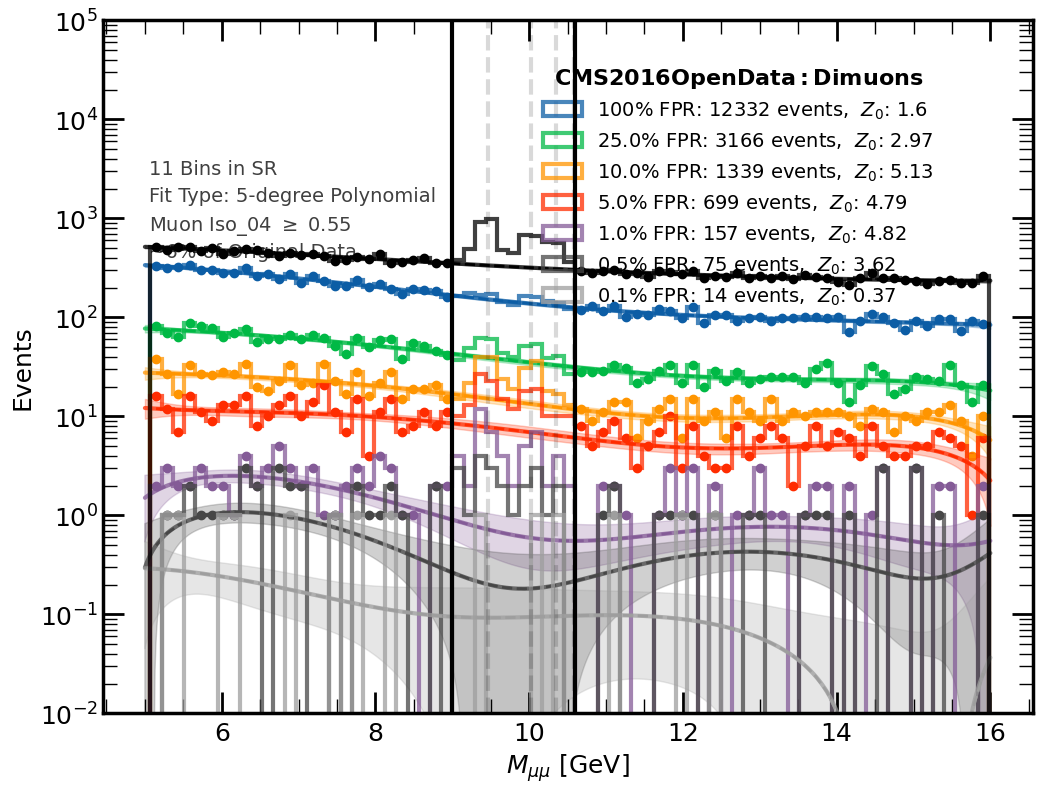

In [53]:

"""
PLOT HISTOGRAM ON SMALL TEST SET
"""
pseudo_e_to_plot = 0
save_data = plot_histograms_with_fits(fpr_thresholds, all_test_data_splits[pseudo_e_to_plot], all_scores_splits[pseudo_e_to_plot], score_cutoffs[pseudo_e_to_plot], scaler, bkg_fit_degree,f"upsilon OS\n", 
                          SB_left, SR_left, SR_right, SB_right, take_score_avg=False)

with open(f"{plot_data_dir}{data_prefix}_histogram_data_{bkg_fit_degree}_{num_bins_SR}.pickle", "wb") as ofile:
    pickle.dump(save_data, ofile)

print("Saved Data to " + f"{plot_data_dir}{data_prefix}_histogram_data_{bkg_fit_degree}_{num_bins_SR}.pickle")

/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/stats_functions.py:185: RuntimeWarning: invalid value encountered in log
  log_likelihood += n_prime * np.log(lambda_prime) - lambda_prime - loggamma(n_prime + 1)


1 24.744448973095928 964.2555510269041 0.5262880046575774
0.25 15.607173303963577 249.39282669603642 0.6527336943615487
0.1 -3.7321089407075334 102.73210894070753 0.0


/global/homes/r/rikab/.conda/envs/rikab/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/global/homes/r/rikab/.conda/envs/rikab/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.05 1.5073822469062534 57.49261775309375 0.5316228481019777
0.01 0.21702669727561918 15.78297330272438 0.05011977223506408
0.005 0.10719393479356665 7.892806065206433 0.03813756431195399
0.001 -0.12412307037010861 1.1241230703701086 0.0
2955.9974733872473 3586.0025266127527 28.921615567139796
[ 2.38151722e+02  2.29121212e+02 -5.60803758e+01  5.35821803e+00
 -2.36583943e-01  4.04809890e-03]


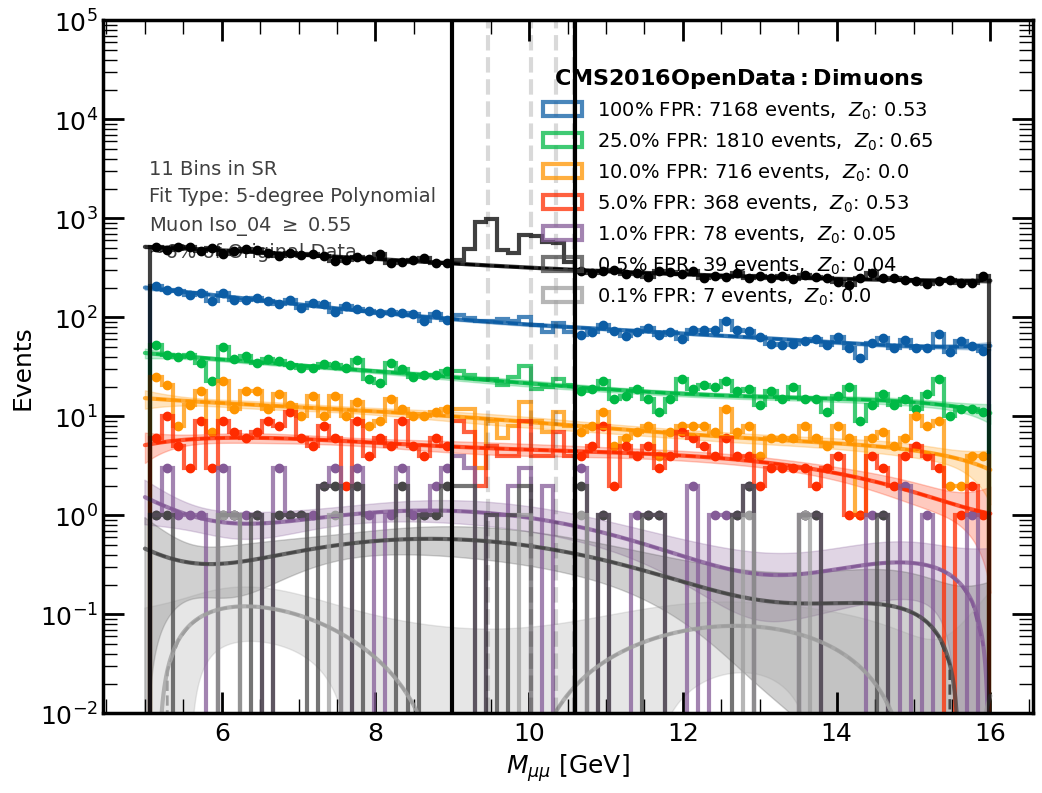

In [54]:


"""
PLOT HISTOGRAM ON ALTERNATIVE TEST SET
"""
save_data = plot_histograms_with_fits(fpr_thresholds, all_alt_data_splits[pseudo_e_to_plot]["alt"], 
                                      all_alt_scores_splits[pseudo_e_to_plot]["alt"], score_cutoffs[pseudo_e_to_plot], 
                                      scaler, bkg_fit_degree, f"upsilon SS",SB_left, SR_left, SR_right, SB_right, 
                                      take_score_avg=False)

with open(f"{plot_data_dir}{data_prefix}_histogram_data_alt_{bkg_fit_degree}_{num_bins_SR}.pickle", "wb") as ofile:
    pickle.dump(save_data, ofile)


# Feature Plots

In [55]:
from helpers.data_transforms import scaled_to_physical_transform

def plot_features(fpr_thresholds, data_dict_by_fold, scores_dict_by_fold, score_cutoffs_by_fold, mass_scalar, SR_left, SR_right, n_folds= 5, take_score_avg=True):



    pre_isoation_cut_data = SR_data_OS

    save_data = {}
    save_data["fpr_thresholds"] = fpr_thresholds
    save_data["features"] = []

    n_features = len(feature_set) - 1
    nbins = 40

    bins = {
        "dimu_pt": np.linspace(0, 150, nbins),
        "mu0_ip3d": np.logspace(-6, 0, nbins),
        "mu1_ip3d": np.logspace(-6, 0, nbins),
    }
    labels = {
        "dimu_pt": "Dimuon $p_T$ [GeV]",
        "mu0_ip3d": "Muon 1 IP3D [cm]",
        "mu1_ip3d": "Muon 2 IP3D [cm]",
    }


    all_data = np.vstack([data_dict_by_fold[i] for i in range(n_folds)])
    all_scores = np.vstack([scores_dict_by_fold[i].reshape(-1,1) for i in range(n_folds)]) 
    all_masses = mass_scalar.inverse_transform(all_data[:,-1].reshape(-1,1))

    all_features = {i:all_data[:,i] for i in range(n_features)}
    all_features = {i: scaled_to_physical_transform(all_features[i], preprocessing_info[feature_set[i]], cushion = 0.02).reshape(-1,1) for i in range(n_features)}
    

    in_SR = (all_masses >= SR_left ) & (all_masses <= SR_right)
    in_SBL = (all_masses < SR_left )
    in_SBH = (all_masses > SR_right )

    mass_SBL = all_masses[in_SBL]
    mass_SR = all_masses[in_SR]
    mass_SBH = all_masses[in_SBH]

    feature_SBL = all_scores[in_SBL]
    feature_SR = all_scores[in_SR]
    feature_SBH = all_scores[in_SBH]

    feature_cut_points = np.linspace(np.min(all_scores), np.max(all_scores), 10000)
    

        # For each cut, calculate the number of signal and background events in the SR
    num_in_SBL = []
    num_in_SR = []
    num_in_SBH = []
    FPR = []
    for cut in feature_cut_points:
        num_in_SBL.append(np.sum(feature_SBL >= cut)/len(feature_SBL))
        num_in_SR.append(np.sum(feature_SR >= cut)/len(feature_SR))
        num_in_SBH.append(np.sum(feature_SBH >= cut)/len(feature_SBH))

        FPR.append((np.sum(feature_SBH >= cut)+np.sum(feature_SBL >= cut))/(len(feature_SBH)+len(feature_SBL)))


    
    
    fig, ax = plt.subplots(1, n_features, figsize = (5*n_features, 5))


    for i_feat in range(n_features):

        ax[i_feat].hist(pre_isoation_cut_data[feature_set[i_feat]], bins=bins[feature_set[i_feat]], lw = 3, histtype = "step", color = "black",label = "Pre-Isolation Cut", alpha = 0.75)


    
    for t, threshold in enumerate(fpr_thresholds):
        
        filtered_features = {i:[] for i in range(n_features)}

        best_feature_cut = feature_cut_points[np.argmin(np.abs(np.array(FPR)-threshold))]

        for i_feat in range(n_features):

            # Apply the cut
            indices = (in_SR) & (all_scores >= best_feature_cut)
            filtered_features[i_feat] = all_features[i_feat][indices]

            # Get only the SR


        save_data["features"].append(filtered_features)

        for i_feat in range(n_features):

            label_string = str(round(100*threshold, 2))+"% FPR"
            


            ax[i_feat].hist( filtered_features[i_feat], bins=bins[feature_set[i_feat]], lw = 3, histtype = "step", color = f"C{t}",label = label_string, alpha = 0.75)
            ax[i_feat].set_yscale("log")
            if i_feat in [1, 2]:
                ax[i_feat].set_xscale("log")
                ax[i_feat].set_xticks([1e-3, 1e-2, 1e-1])
            ax[i_feat].set_xlabel(labels[feature_set[i_feat]])
            ax[i_feat].set_ylim(1e-1, 5*1e3)

            ax[i_feat].tick_params(labelsize = 16)

            if i_feat > 0:
                ax[i_feat].set_yticklabels([])


           

    legend_title = r"Upsilon Resonances: Iso, Opp. Sign"
    plt.legend(loc = (1.05, 0.4), fontsize = 16)

    ax[0].set_ylabel("Events", fontsize = 18)
    plt.subplots_adjust(wspace=0)
    
    return save_data

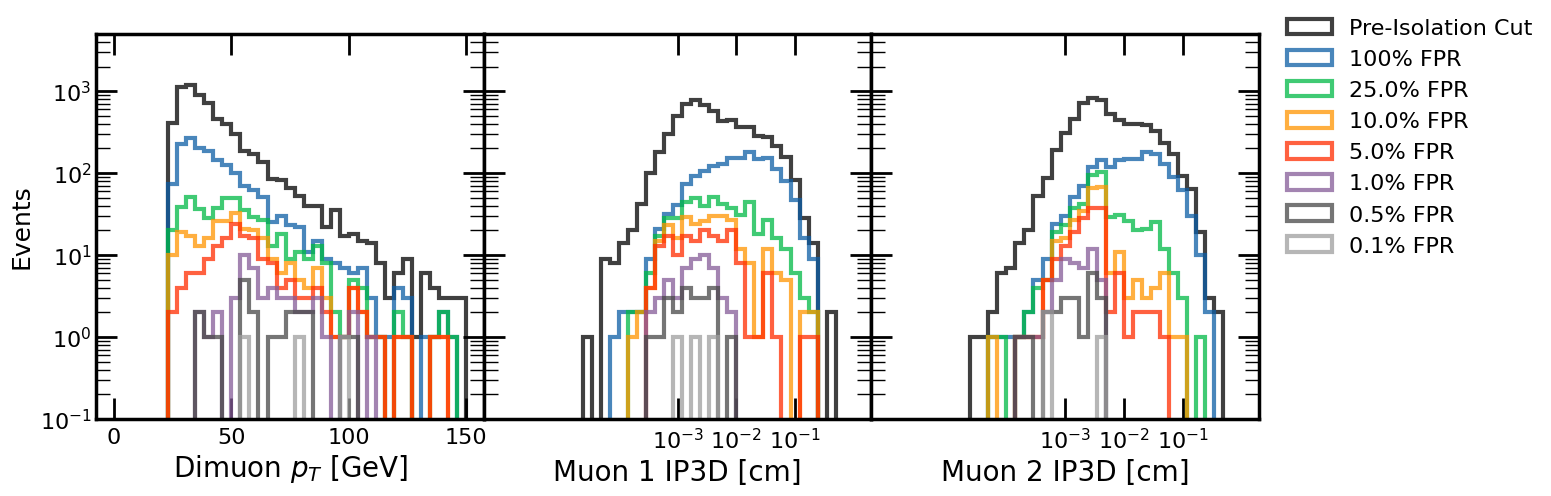

In [56]:
save_data = plot_features(fpr_thresholds, all_test_data_splits[pseudo_e_to_plot], all_scores_splits[pseudo_e_to_plot], score_cutoffs[pseudo_e_to_plot], scaler, SR_left, SR_right, take_score_avg=False)

with open(f"{plot_data_dir}{data_prefix}_feature_data_{bkg_fit_degree}_{num_bins_SR}.pickle", "wb") as ofile:
    pickle.dump(save_data, ofile)

# Signficance Plots

In [57]:
n_folds = 5


# determine fpr thresholds as before
# yes this is repeated code
fpr_thresholds_finegrained = np.logspace(0, -3, 25)
#fpr_thresholds = np.linspace(1, 0 , 50)

plot_bins_all, plot_bins_SR, plot_bins_left, plot_bins_right, plot_centers_all, plot_centers_SR, plot_centers_SB = get_bins(SR_left, SR_right, SB_left, SB_right, num_bins_SR = num_bins_SR)



        
def get_classifier_metrics_high_stats(dataset_by_pseudo_e, scores_by_pseudo_e, mass_scalar):

    num_experiments = num_pseudoexperiments
    S_yield, B_yield = np.empty((fpr_thresholds_finegrained.shape[0], num_experiments)), np.empty((fpr_thresholds_finegrained.shape[0], num_experiments))
    significances = np.empty((fpr_thresholds_finegrained.shape[0], num_experiments))


    for pseudo_e in range(num_experiments):

        data_dict_by_fold = dataset_by_pseudo_e[pseudo_e]
        scores_dict_by_fold = scores_by_pseudo_e[pseudo_e]

        all_data = np.vstack([data_dict_by_fold[i] for i in range(n_folds)])
        all_scores = np.vstack([scores_dict_by_fold[i].reshape(-1,1) for i in range(n_folds)]) 
        all_masses = mass_scalar.inverse_transform(all_data[:,-1].reshape(-1,1))
        in_SR = (all_masses >= SR_left ) & (all_masses <= SR_right)
        in_SBL = (all_masses < SR_left )
        in_SBH = (all_masses > SR_right )

        mass_SBL = all_masses[in_SBL]
        mass_SR = all_masses[in_SR]
        mass_SBH = all_masses[in_SBH]

        feature_SBL = all_scores[in_SBL]
        feature_SR = all_scores[in_SR]
        feature_SBH = all_scores[in_SBH]
        
        # Get a list of all possible cuts for the feature
        feature_cut_points = np.linspace(np.min(all_scores), np.max(all_scores), 10000)

         # For each cut, calculate the number of signal and background events in the SR
        num_in_SBL = []
        num_in_SR = []
        num_in_SBH = []
        FPR = []
        for cut in feature_cut_points:
            num_in_SBL.append(np.sum(feature_SBL >= cut)/len(feature_SBL))
            num_in_SR.append(np.sum(feature_SR >= cut)/len(feature_SR))
            num_in_SBH.append(np.sum(feature_SBH >= cut)/len(feature_SBH))

            FPR.append((np.sum(feature_SBH >= cut)+np.sum(feature_SBL >= cut))/(len(feature_SBH)+len(feature_SBL)))



        print(f"On pseudo experiment {pseudo_e+1}...")
        for t, threshold in enumerate(fpr_thresholds_finegrained):




            # Use interpolation to find the cut point that gives the desired FPR
            best_feature_cut = feature_cut_points[np.argmin(np.abs(np.array(FPR)-threshold))]


            mass_SBL_cut = mass_SBL[feature_SBL >= best_feature_cut]
            mass_SR_cut = mass_SR[feature_SR >= best_feature_cut]
            mass_SBH_cut = mass_SBH[feature_SBH >= best_feature_cut]

            # Concatenate to get the full mass spectrum
            filtered_masses = np.concatenate((mass_SBL_cut, mass_SR_cut, mass_SBH_cut))
            

             # calculate significance of bump
            popt, pcov, chi2, y_vals, n_dof = curve_fit_m_inv(filtered_masses, bkg_fit_degree, SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_SB)
            S,B, q0 = calculate_test_statistic(filtered_masses, SR_left, SR_right, SB_left, SB_right, num_bins_SR, degree = bkg_fit_degree, starting_guess = popt, verbose_plot = False)
            print("S: ", S, "B: ", B, "sqrt(q0): ", np.sqrt(q0))

            significances[t, pseudo_e] = np.sqrt(q0)

            if threshold == 1.0:

                mu = (S) / (S + B)
                likelihood_ratios = (all_scores) / (1 - all_scores)
                weights = (likelihood_ratios - (1-mu)) / mu
                weights = np.clip(weights, 0, 1e9)

                popt, pcov, chi2, y_vals, n_dof = curve_fit_m_inv(all_masses, bkg_fit_degree, SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_SB, weights = weights)
                s, b, bonus_q0, popt = calculate_test_statistic(all_masses,  SR_left, SR_right, SB_left, SB_right, num_bins_SR,  weights = weights, degree = bkg_fit_degree, verbose_plot = False, starting_guess = popt, return_popt = True)

                print("Full Likelihood Fit: S: ", s, "B: ", b, "sqrt(q0): ", np.sqrt(bonus_q0))


        
    
    return significances, bonus_q0



In [58]:
# Reformat alt to not have the 'alt' key
all_alt_data_splits_formatted = {}
all_alt_scores_splits_formatted = {}
for pseudo_e in range(num_pseudoexperiments):
    all_alt_data_splits_formatted[pseudo_e] = all_alt_data_splits[pseudo_e]["alt"]
    all_alt_scores_splits_formatted[pseudo_e] = all_alt_scores_splits[pseudo_e]["alt"]



In [59]:
significances, full_q0 = get_classifier_metrics_high_stats(all_test_data_splits, all_scores_splits, scaler)
with open(f"{plot_data_dir}{data_prefix}_significances_{bkg_fit_degree}_{num_bins_SR}.pickle", "wb") as ofile:
    pickle.dump(significances, ofile)
with open(f"{plot_data_dir}{data_prefix}_full_q0_{bkg_fit_degree}_{num_bins_SR}.pickle", "wb") as ofile:
    pickle.dump(full_q0, ofile)



significances_alt, full_q0_alt = get_classifier_metrics_high_stats(all_alt_data_splits_formatted, all_alt_scores_splits_formatted, scaler)
with open(f"{plot_data_dir}{data_prefix}_significances_alt_{bkg_fit_degree}_{num_bins_SR}.pickle", "wb") as ofile:
    pickle.dump(significances_alt, ofile)
with open(f"{plot_data_dir}{data_prefix}_full_q0_alt_{bkg_fit_degree}_{num_bins_SR}.pickle", "wb") as ofile:
    pickle.dump(full_q0_alt, ofile)



On pseudo experiment 1...


/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/stats_functions.py:185: RuntimeWarning: invalid value encountered in log
  log_likelihood += n_prime * np.log(lambda_prime) - lambda_prime - loggamma(n_prime + 1)


S:  97.16093502145168 B:  1594.8390649785483 sqrt(q0):  1.5955802336321205


/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/stats_functions.py:118: RuntimeWarning: invalid value encountered in log
  log_likelihood += n_prime * np.log(lambda_prime) - lambda_prime - loggamma(n_prime + 1)


Full Likelihood Fit: S:  1146.3328092755282 B:  1705.9786018158402 sqrt(q0):  6.390764976131575
S:  119.09749464946276 B:  1184.9025053505372 sqrt(q0):  2.2422302403018834
S:  133.41888167259765 B:  889.5811183274024 sqrt(q0):  2.875178244783476
S:  129.62615770331354 B:  668.3738422966865 sqrt(q0):  3.2037918469317557
S:  113.63306947101353 B:  518.3669305289865 sqrt(q0):  3.180989530216608
S:  104.42569349925617 B:  388.57430650074383 sqrt(q0):  3.3474561959149716
S:  114.83046868572796 B:  280.16953131427204 sqrt(q0):  4.189224432811505
S:  134.01767180069018 B:  206.98232819930982 sqrt(q0):  5.4821830659759
S:  111.28330439611958 B:  163.71669560388042 sqrt(q0):  5.126149314979984
S:  110.27860030966322 B:  115.72139969033678 sqrt(q0):  5.74325371288894
S:  63.28349651026542 B:  114.71650348973458 sqrt(q0):  4.144152307667738


/global/homes/r/rikab/.conda/envs/rikab/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/global/homes/r/rikab/.conda/envs/rikab/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


S:  74.14215489784084 B:  78.85784510215916 sqrt(q0):  4.827960790086416
S:  66.35865292461082 B:  57.64134707538918 sqrt(q0):  4.887396024922627
S:  66.03710488232701 B:  35.962895117672986 sqrt(q0):  5.55225172841604
S:  56.68385490605987 B:  24.31614509394013 sqrt(q0):  5.435192859451593
S:  32.262879602907184 B:  30.737120397092816 sqrt(q0):  3.8156489858971363
S:  38.62046024171512 B:  12.379539758284874 sqrt(q0):  4.81595797669808
S:  32.5305179861231 B:  8.469482013876895 sqrt(q0):  4.545999644844073
S:  17.993132364357592 B:  10.006867635642408 sqrt(q0):  3.343396009407802
S:  15.22375237049586 B:  5.776247629504139 sqrt(q0):  3.357516830562554
S:  7.698480580758658 B:  5.301519419241342 sqrt(q0):  2.0000306669182173
S:  6.168687120765526 B:  3.831312879234474 sqrt(q0):  1.8349572110451566
S:  1.1254486930880279 B:  2.874551306911972 sqrt(q0):  0.4324323592349173
S:  0.4935112617972144 B:  3.5064887382027856 sqrt(q0):  0.25770321901878157
S:  0.5955069729976183 B:  2.4044930270

/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/stats_functions.py:185: RuntimeWarning: invalid value encountered in log
  log_likelihood += n_prime * np.log(lambda_prime) - lambda_prime - loggamma(n_prime + 1)


S:  24.744448973095928 B:  964.2555510269041 sqrt(q0):  0.5262880046575774


/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/stats_functions.py:118: RuntimeWarning: invalid value encountered in log
  log_likelihood += n_prime * np.log(lambda_prime) - lambda_prime - loggamma(n_prime + 1)


Full Likelihood Fit: S:  225.10718162066428 B:  1535.4714143232661 sqrt(q0):  0.9816226793091307
S:  23.12663837122284 B:  736.8733616287772 sqrt(q0):  0.5635375737869855
S:  23.04178970313876 B:  548.9582102968612 sqrt(q0):  0.6491485547135472
S:  6.338045035173593 B:  417.6619549648264 sqrt(q0):  0.2065261396180862
S:  17.507438436699942 B:  310.49256156330006 sqrt(q0):  0.6559975834678317
S:  6.222877832070168 B:  242.77712216792983 sqrt(q0):  0.26775031502691127
S:  21.140208146707238 B:  175.85979185329276 sqrt(q0):  1.0419864791158473
S:  14.327306531967707 B:  134.6726934680323 sqrt(q0):  1.3024556267637803
S:  -3.7321089407075334 B:  102.73210894070753 sqrt(q0):  0.0
S:  0.9690687256277926 B:  82.03093127437221 sqrt(q0):  0.3630581022914036


/global/homes/r/rikab/.conda/envs/rikab/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/global/homes/r/rikab/.conda/envs/rikab/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


S:  2.111465780854928 B:  63.88853421914507 sqrt(q0):  0.17734071696886203
S:  1.7522016109458036 B:  51.247798389054196 sqrt(q0):  0.18744956949238825
S:  3.7623338023445854 B:  37.237666197655415 sqrt(q0):  0.4630619042884613
S:  2.6044329012704672 B:  30.395567098729533 sqrt(q0):  0.3629265470617033
S:  2.2842830352218044 B:  21.715716964778196 sqrt(q0):  0.4445607671033469
S:  -0.580298044155068 B:  18.580298044155068 sqrt(q0):  0.0
S:  0.21702669727561918 B:  15.78297330272438 sqrt(q0):  0.05011977223506408
S:  3.7700387193804357 B:  11.229961280619564 sqrt(q0):  1.069518103507931
S:  -1.823986928287816 B:  9.823986928287816 sqrt(q0):  0.0
S:  0.2507086839224284 B:  6.749291316077572 sqrt(q0):  0.09591708696983622
S:  0.14260624083129603 B:  4.857393759168704 sqrt(q0):  0.06440444721003633
S:  -0.7671959285715189 B:  3.767195928571519 sqrt(q0):  0.0
S:  -1.0345728573820292 B:  4.034572857382029 sqrt(q0):  0.0
S:  1.1576182625434828 B:  1.8423817374565172 sqrt(q0):  0.7810778771120

In [60]:
from helpers.plotting import feature_bins


def feature_cut_ROCS(feature, test_data_splits, mass_scalar, fit_degree, title, SB_left, SR_left, SR_right, SB_right, flip = False, index = 0, random = False):
    """
    Plot the feature cuts for the given data, scores, and score cutoffs.

    Parameters
    ----------
    feature : str
        The feature to plot the cuts for.
    fpr_thresholds : list
        The list of FPR thresholds to plot.
    test_data_dict : dict
        The dictionary of test data.
    mass_scalar : sklearn.preprocessing.StandardScaler
        The mass scaler.
    fit_type : str
        The type of fit to use for the background.
    title : str
        The title of the plot.
    SB_left : float
        The left side of the sideband.
    SR_left : float
        The left side of the signal region.
    SR_right : float
        The right side of the signal region.
    SB_right : float
        The right side of the sideband.
    """
    num_experiments = num_pseudoexperiments
    fpr_thresholds = fpr_thresholds_finegrained
    S_yield = np.zeros((len(fpr_thresholds), num_experiments))
    B_yield = np.zeros((len(fpr_thresholds), num_experiments))
    background_errors = np.zeros((len(fpr_thresholds), num_experiments))
    significances = np.zeros((len(fpr_thresholds), num_experiments))



    for (e, pseudo_e) in enumerate(tqdm(range(num_experiments))):

        all_nfolds = np.concatenate([test_data_splits[pseudo_e][i] for i in range(n_folds)])
        

        if random:
            feature_of_interest = np.random.uniform(0, 1, len(all_nfolds[:,-1]))
        else:
            feature_of_interest = all_nfolds[:,index]


        masses = mass_scalar.inverse_transform(np.array(all_nfolds[:,-1]).reshape(-1,1))[:,0]



        if flip:
            feature_of_interest = -feature_of_interest
           

        # Split into SBL, SR, and SBH
        # print(masses.shape, feature_of_interest.shape)
        feature_SBL = feature_of_interest[masses < SR_left]
        feature_SR = feature_of_interest[(masses >= SR_left) & (masses <= SR_right)]
        feature_SBH = feature_of_interest[masses > SR_right]




        # Get a list of all possible cuts for the feature
        mass_SBL = masses[masses < SR_left]
        mass_SR = masses[(masses >= SR_left) & (masses <= SR_right)]
        mass_SBH = masses[masses > SR_right]



        feature_cut_points = np.linspace(np.min(feature_of_interest), np.max(feature_of_interest), 10000)

        FPR = []
        for cut in feature_cut_points:
            FPR.append((np.sum(feature_SBH >= cut)+np.sum(feature_SBL >= cut))/(len(feature_SBH)+len(feature_SBL)))



        plot_bins_all, plot_bins_SR, plot_bins_left, plot_bins_right, plot_centers_all, plot_centers_SR, plot_centers_SB = get_bins(SR_left, SR_right, SB_left, SB_right, num_bins_SR = num_bins_SR)
        fpr_results = {threshold:{"S":0, "B":0, "S_over_B":0, "signif":0} for threshold in fpr_thresholds}



        # fig, ax = newplot("full", aspect_ratio = 1.5)
        for t, threshold in enumerate(fpr_thresholds):


            # Use interpolation to find the cut point that gives the desired FPR
            best_feature_cut = feature_cut_points[np.argmin(np.abs(np.array(FPR)-threshold))]
            # print(np.min(feature_of_interest), np.max(feature_of_interest), best_feature_cut)

            # Make the cuts to both the feature and the mass
            feature_SBL_cut = feature_SBL[feature_SBL >= best_feature_cut]
            feature_SR_cut = feature_SR[feature_SR >= best_feature_cut]
            feature_SBH_cut = feature_SBH[feature_SBH >= best_feature_cut]

    

            mass_SBL_cut = mass_SBL[feature_SBL >= best_feature_cut]
            mass_SR_cut = mass_SR[feature_SR >= best_feature_cut]
            mass_SBH_cut = mass_SBH[feature_SBH >= best_feature_cut]


            # Concatenate to get the full mass spectrum
            filtered_masses = np.concatenate((mass_SBL_cut, mass_SR_cut, mass_SBH_cut))
            

            # calculate significance of bump
            popt, pcov, chi2, y_vals, n_dof = curve_fit_m_inv(filtered_masses, fit_degree, SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_SB)
            S,B, q0 = calculate_test_statistic(filtered_masses, SR_left, SR_right, SB_left, SB_right, num_bins_SR, degree = fit_degree, starting_guess = popt, verbose_plot = False)
            print("S: ", S, "B: ", B, "sqrt(q0): ", np.sqrt(q0))

            significances[t, pseudo_e] = np.sqrt(q0)

    
    return significances


In [61]:
# for i in range(n_folds):
#     all_test_data_splits[pseudo_e][i][:,0] = all_test_data_splits[pseudo_e][i][:,1] + all_test_data_splits[pseudo_e][i][:,2]

In [66]:

feature_SIGs = {}
feature_SIGs_alt = {}

flip_features = [False, True, True, False] 



# Opposite Sign
for (i, feature) in enumerate(["dimu_pt", "mu0_ip3d", "mu1_ip3d", "random"]):
    print(feature)
    feature_SIGs[feature] = feature_cut_ROCS(feature, all_test_data_splits, scaler, bkg_fit_degree, f"", SB_left, SR_left, SR_right, SB_right, flip = flip_features[i], index = i, random = (feature == "random"))

    with open(f"{plot_data_dir}{data_prefix}_significances_{feature}_{bkg_fit_degree}_{num_bins_SR}.pickle", "wb") as ofile:
        pickle.dump(feature_SIGs[feature], ofile)

# Same Sign
for (i, feature) in enumerate(["dimu_pt", "mu0_ip3d", "mu1_ip3d", "random"]):
    print(feature)
    feature_SIGs_alt[feature] = feature_cut_ROCS(feature, all_alt_data_splits_formatted, scaler, bkg_fit_degree, f"", SB_left, SR_left, SR_right, SB_right, flip = flip_features[i], index = i, random = (feature == "random"))

    with open(f"{plot_data_dir}{data_prefix}_significances_alt_{feature}_{bkg_fit_degree}_{num_bins_SR}.pickle", "wb") as ofile:
        pickle.dump(feature_SIGs_alt[feature], ofile)

  


In [63]:
# Add the ordinary TPR, FPR, ROC, SIC to dictionary with key "CATHODE"
feature_SIGs["CATHODE"] = significances
feature_SIGs_alt["CATHODE"] = significances_alt


max observed significance 3.1293626304432953
max observed significance 4.125542021540008
max observed significance 3.530235666808067
max observed significance 5.74325371288894


<>:36: SyntaxWarning: invalid escape sequence '\P'
<>:36: SyntaxWarning: invalid escape sequence '\P'
/tmp/ipykernel_258836/1886333117.py:36: SyntaxWarning: invalid escape sequence '\P'
  ax.set_ylabel("Significance $Z_0 = \Phi^{-1}(1-p_0)$")


(0.0, 12.0)

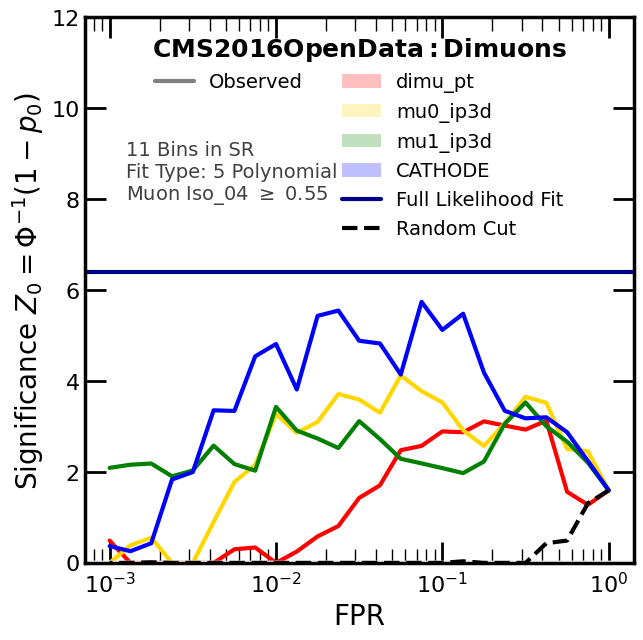

In [64]:



# FPR Variant of SIC
fig, ax = newplot("full", use_tex = latex_flag)
colors = ["red", "gold", "green", "blue"]
for (i, key) in enumerate(["dimu_pt", "mu0_ip3d", "mu1_ip3d", "CATHODE"]):

    SIG_observed = feature_SIGs[key][:,0]
    ax.plot(fpr_thresholds_finegrained, SIG_observed, color = colors[i])
    print("max observed significance", np.max(SIG_observed))

# Artificially make a legend
# plt.axhline(0, color = "Grey", linestyle = "--", label = "Expected $\pm$ 1, 2$\sigma$")
plt.axhline(0, color = "Grey", label = "Observed")

# add dummy white space to legend so that column 1 has the same height as column 2
num_features = len(feature_SIGs.keys()) 
for i in range(num_features):
    plt.axhline(0, color = "white", label = " ")


# Add the keys in a seperate column with filled color
for (i, key) in enumerate(["dimu_pt", "mu0_ip3d", "mu1_ip3d", "CATHODE"]):
    ax.hist([-1], color = colors[i], alpha = 0.25, label = key, histtype = "stepfilled")



bonus_q0 = full_q0
ax.axhline(np.sqrt(bonus_q0), color = "darkblue", linestyle = "-", label = "Full Likelihood Fit")

# print(feature_SIGs["CATHODE"][:,0])

SIG_observed = feature_SIGs["random"][:,0]
# SIG_median, SIG_lower, SIG_upper, SIG_2lower, SIG_2upper = get_median_percentiles(feature_SIGs["random"][:,1:])

ax.plot(fpr_thresholds_finegrained, SIG_observed, linestyle = "dashed", color = "black", label = "Random Cut")
ax.set_xlabel("FPR")
ax.set_ylabel("Significance $Z_0 = \Phi^{-1}(1-p_0)$")


line1 = f"{num_bins_SR -1 } Bins in SR"
line2 = f"Fit Type: {bkg_fit_degree} Polynomial"
line3 = r"Muon Iso_04 $\geq$ 0.55"
line4 = r""

starting_x = 0.075
starting_y = 0.775
delta_y = 0.04
text_alpha = 0.75
ax.text(starting_x, starting_y - 0 * delta_y, line1, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha, zorder = 10)
ax.text(starting_x, starting_y - 1 * delta_y, line2, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha, zorder = 10)
ax.text(starting_x, starting_y - 2 * delta_y, line3, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha, zorder = 10)
ax.text(starting_x, starting_y - 3 * delta_y, line4, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha, zorder = 10)


legend_title = r"$\bf{CMS 2016 Open Data: Dimuons}$"

plt.legend(title = legend_title, loc = "upper center", ncol = 2, fontsize = 14)
plt.xscale("log")
plt.ylim(0.0, 12)


<>:40: SyntaxWarning: invalid escape sequence '\P'
<>:40: SyntaxWarning: invalid escape sequence '\P'
/tmp/ipykernel_258836/351928285.py:40: SyntaxWarning: invalid escape sequence '\P'
  ax.set_ylabel("Significance $Z_0 = \Phi^{-1}(1-p_0)$")


(0.0, 10.0)

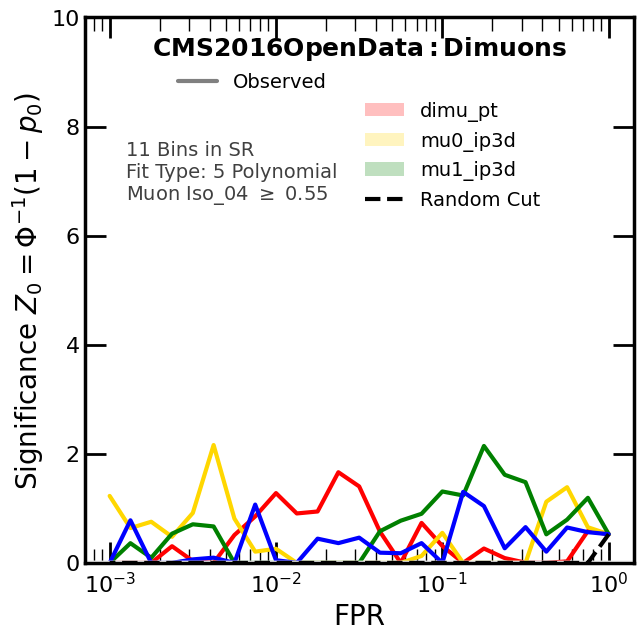

In [65]:
# same plot but for the alternative data

fig, ax = newplot("full", use_tex = latex_flag)
colors = ["red", "gold", "green", "blue", "black"]

for (i, key) in enumerate(["dimu_pt", "mu0_ip3d", "mu1_ip3d", "CATHODE"]):

    SIG_observed = feature_SIGs_alt[key][:,0]



    ax.plot(fpr_thresholds_finegrained, SIG_observed, color = colors[i])

    if key == "random":
        ax.plot(fpr_thresholds_finegrained, SIG_observed, linestyle = "dashed", color = colors[i], alpha = 0.5)
      

# Artificially make a legend
# plt.axhline(0, color = "Grey", linestyle = "--", label = "Expected $\pm$ 1, 2$\sigma$")
plt.axhline(0, color = "Grey", label = "Observed")

# add dummy white space to legend so that column 1 has the same height as column 2
num_features = len(feature_SIGs.keys())
for i in range(num_features):
    plt.axhline(0, color = "white", label = " ")

# Add the keys in a seperate column with filled color

for (i, key) in enumerate(["dimu_pt", "mu0_ip3d", "mu1_ip3d"]):

    ax.hist([-1], color = colors[i], alpha = 0.25, label = key, histtype = "stepfilled")

# print(feature_SIGs["CATHODE"][:,0])

SIG_observed = feature_SIGs_alt["random"][:,0]
# SIG_median, SIG_lower, SIG_upper, SIG_2lower, SIG_2upper = get_median_percentiles(feature_SIGs_alt["random"][:,1:])

ax.plot(fpr_thresholds_finegrained, SIG_observed, linestyle = "dashed", color = "black", label = "Random Cut")
ax.set_xlabel("FPR")
ax.set_ylabel("Significance $Z_0 = \Phi^{-1}(1-p_0)$")


line1 = f"{num_bins_SR -1 } Bins in SR"
line2 = f"Fit Type: {bkg_fit_degree} Polynomial"
line3 = r"Muon Iso_04 $\geq$ 0.55"
line4 = r""

starting_x = 0.075
starting_y = 0.775
delta_y = 0.04
text_alpha = 0.75
ax.text(starting_x, starting_y - 0 * delta_y, line1, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha, zorder = 10)
ax.text(starting_x, starting_y - 1 * delta_y, line2, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha, zorder = 10)
ax.text(starting_x, starting_y - 2 * delta_y, line3, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha, zorder = 10)
ax.text(starting_x, starting_y - 3 * delta_y, line4, transform=ax.transAxes, fontsize=14, verticalalignment='top', alpha = text_alpha, zorder = 10)


legend_title = r"$\bf{CMS 2016 Open Data: Dimuons}$"

plt.legend(title = legend_title, loc = "upper center", ncol = 2, fontsize = 14)

plt.xscale("log")
plt.ylim(0.0, 10)
# plt.yscale("log")




